# Homework 1
* Author: Kenji Oman ([github profile](https://github.com/kenjioman))
* Date: 15 February 2019

Original homework can be found [in the github reopo](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week01.pdf).  Questions copied here in line with the work to make it easier to follow.

In [1]:
# Make neecessary imports
import numpy as np
import scipy.stats as sps

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('talk')

## Problem 1
Suppose the globe tossing data had turned out to be 8 water in 15 tosses.
Construct the posterior distribution, using grid approximation. Use the
same flat prior as before.

In [2]:
# First, define the number of points to use in the grid, so we can switch this easily
n_points = 1_000

# Now, let's construct out grid of points
p_grid = np.linspace(0, 1, n_points)

# Define our prior
prior = np.ones(n_points)

# And likelihood (where we specify we saw 8 waters in 15 tosses)
likelihood = sps.binom.pmf(k=8, n=15, p=p_grid)

# The raw posterior
raw_posterior = likelihood * prior

# The normalized posterior
posterior = raw_posterior / raw_posterior.sum()

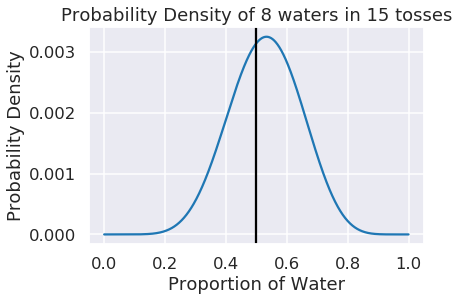

In [3]:
# Let's visualize this
plt.plot(p_grid, posterior)
plt.xlabel('Proportion of Water')
plt.ylabel('Probability Density')
plt.title('Probability Density of 8 waters in 15 tosses')
plt.axvline(0.5, color='k')
plt.show()

We observe that, with 8 waters in 15 tosses, the distribution is just slightly shifted to the right (mode, also called _Maximum a posteriori_, or MAP, is above 0.5, or more specifically, at 8/15 ~= 0.533).

----

### Matching the given solutions
Now, some work to compare with the solution (did this after looking at the solutions and saw this is what is given as a means of checking the answer).

In [4]:
# Let's draw samples from this distribution
np.random.seed(100)
sample = np.random.choice(p_grid, size=int(1e5), replace=True, p=posterior)

In [5]:
# Now, let's calculate the mean and 95% percentile interval
mean = sample.mean()
percentile = np.percentile(sample, [0.5, 99.5])
print('Mean: {:.3f}'.format(mean))
print('99-percentile interval: {:.3f} - {:.3f}'.format(*percentile))

Mean: 0.529
99-percentile interval: 0.235 - 0.810


Comparing with the solutions, my work checks out!

## Problem 2
Start over in 1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5. This corresponds to prior information that a majority
of the Earth’s surface is water. What difference does the better prior make?
If it helps, compare posterior distributions (using both priors) to the true
value p = 0.7.

In [6]:
# Define our new prior. Need to combine two arrays -- one with zeros, and one
# with ones, both at the right shape
prior_2 = np.concatenate([np.zeros(int(n_points/2)), np.ones(int(n_points/2))])

# The raw posterior
raw_posterior_2 = likelihood * prior_2

# The normalized posterior
posterior_2 = raw_posterior_2 / raw_posterior_2.sum()

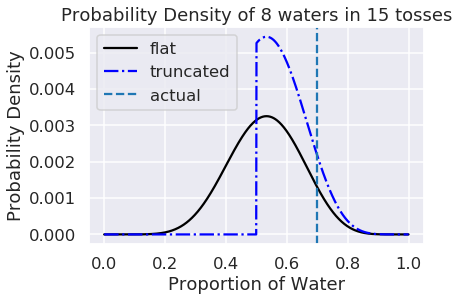

In [7]:
# Let's visualize this, this time plotting both posterior distributions
plt.plot(p_grid, posterior, color='k', label='flat')
plt.plot(p_grid, posterior_2, color='b', linestyle='-.', label='truncated')
plt.xlabel('Proportion of Water')
plt.ylabel('Probability Density')
plt.title('Probability Density of 8 waters in 15 tosses')
plt.axvline(0.7, linestyle='--', label='actual')
plt.legend(loc='upper left')
plt.show()

In [8]:
# Let's take a look at the p-value at the max of both posterior distributions
print('p-value from posterior with flat prior')
print(p_grid[np.where(posterior == posterior.max())])

print('p-value from posterior with truncated prior')
print(p_grid[np.where(posterior_2 == posterior_2.max())])

p-value from posterior with flat prior
[0.53353353]
p-value from posterior with truncated prior
[0.53353353]


From the above, we observe that the MAP (the maximum value of the estimated proportion of water) is equal, regardless of which prior we chose, at p=0.53.  However, the truncated prior has zero probabilty for any p-values below 0.5, while the flat prior allows for these p-values.  This is in alignment with the prior information we fed each model where the second (truncated) model "knows", from the prior information we fed it, that the proportion of water on earth has to be larger than 0.5.

-----

### Matching the given solutions
Once again, the below was written after looking at the solutions, as a way to compare with the solutions.

In [9]:
# Let's draw samples from this distribution
np.random.seed(100)
sample_2 = np.random.choice(p_grid, size=int(1e5), replace=True, p=posterior_2)

In [10]:
# Now, let's calculate the mean and 95% percentile interval
mean_2 = sample_2.mean()
percentile_2 = np.percentile(sample_2, [0.5, 99.5])
print('Mean: {:.3f}'.format(mean_2))
print('99-percentile interval: {:.3f} - {:.3f}'.format(*percentile_2))

Mean: 0.607
99-percentile interval: 0.501 - 0.824


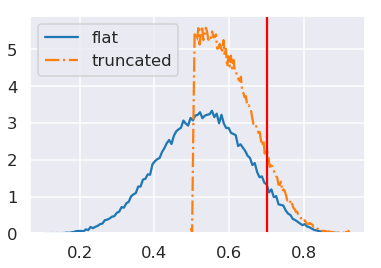

In [11]:
# Now, plot our tow samples -- to make it look "rough" like the solution/ in the book, we need
# to set a fairly small bandwidth, or else things get smoothed out to essentially the posterior
# distribution exactly
sns.kdeplot(sample, bw=0.001, label='flat')
sns.kdeplot(sample_2, bw=0.001, label='truncated', linestyle='-.')
plt.axvline(0.7, label='actual', color='red')
plt.show()

Once again, my work above checks out with the solution!

## Problem 3
This problem is more open-ended than the others. Feel free to collaborate on the solution.

Suppose you want to estimate the Earth’s proportion of
water very precisely. Specifically, you want the 99% percentile interval of the
posterior distribution of p to be only 0.05 wide. This means the distance between the upper and lower bound of the interval should be 0.05. How many
times will you have to toss the globe to do this? I won’t require a precise
answer. I’m honestly more interested in your approach.

-----------------
Probably the easiest way to do this is with a simulation. Let's try it out, using a "known" proportion of water on earth to be p = 0.7.

In [12]:
# Define a function that will, up to a certain N, find the number of trials
# needed to meet our requirements from this problem.
def find_N(N, true_p=0.7, n_points=10_000):
    """
    N {int} - the max number of tosses to try.
    true_p {float} - the "true" proportion of water on earth
    n_points {int} - the number of points to use on our grid
    
    Returns:
    ({str}, {int}) - How many trials were required to meet our theshold, or a statement that
    we need more trials, with the int = the number of trials if found, or -1 if not found
    """

    # Construct out grid of points
    p_grid = np.linspace(0, 1, n_points)

    # Define our prior
    prior = np.ones(n_points)
    
    # initialize our results of the tosses
    results = []
    
    # Also, set a flag for if we found the N that met our theshold
    # (to protect us from falsly saying we didn't find it, if our max N
    # was the value where it finally met the threshold)
    found = False
    
    # Now, start tossing the globe
    for trial in range(N):
        # Test if we got a W/L in this toss
        results.append(sps.bernoulli.rvs(true_p))
        
        # Calculate our likelihood, based off of how many successes we have so far
        likelihood = sps.binom.pmf(k=sum(results), n=(trial+1), p=p_grid)

        # The raw posterior
        raw_posterior = likelihood * prior

        # The normalized posterior
        posterior = raw_posterior / raw_posterior.sum()
        
        # Now, find the boundaries of our percentile interval. First, find the cumulative
        # sum
        cumsum = np.cumsum(posterior)
        
        # Now, I want the p for where this cumsum is 0.005 (or greater, due to precision issues)
        p_lower = p_grid[np.where(cumsum >= 0.005)[0][0]]
        # And for where cumsum is <= 0.995
        p_upper = p_grid[np.where(cumsum <= 0.995)[0][-1]]
        
        # Find the difference
        diff = p_upper - p_lower
        
        # If this difference is <= our desired 0.05, then break the loop
        if diff <= 0.05:
            found = True
            break
        
    # Now that we finished our loop, return the appropriate value
    if found:
        # trial +1 because python starts ranges at 0
        return 'Needed {} trials'.format(trial + 1), (trial + 1)
    else:
        return 'Need more trials', -1

In [13]:
# Try with 10_000 max trials
find_N(10_000)

('Needed 2321 trials', 2321)

We find this is slow, so let's re-create our function, trying to speed it up a bit (specifically, instead of calculating a likelihood each time based off of all our trials so far, only calculate it for the current run, and update the posterior with just this trial's result).

In [14]:
# Define a function that will, up to a certain N, find the number of trials
# needed to meet our requirements from this problem.
def find_N_2(N, true_p=0.7, n_points=10_000):
    """
    N {int} - the max number of tosses to try.
    true_p {float} - the "true" proportion of water on earth
    n_points {int} - the number of points to use on our grid
    
    Returns:
    ({str}, {int}) - How many trials were required to meet our theshold, or a statement that
    we need more trials, with the int = the number of trials if found, or -1 if not found
    """

    # Construct out grid of points
    p_grid = np.linspace(0, 1, n_points)

    # Define our prior
    prior = np.ones(n_points)
    
    # Also, set a flag for if we found the N that met our theshold
    # (to protect us from falsly saying we didn't find it, if our max N
    # was the value where it finally met the threshold)
    found = False
    
    # Now, start tossing the globe
    for trial in range(N):
        # Test if we got a W/L in this toss
        result = sps.bernoulli.rvs(true_p)
        
        # Calculate our likelihood, based off of how many successes we have so far
        likelihood = sps.binom.pmf(k=result, n=1, p=p_grid)

        # The raw posterior
        raw_posterior = likelihood * prior

        # The normalized posterior
        posterior = raw_posterior / raw_posterior.sum()
        
        # Now, find the boundaries of our percentile interval. First, find the cumulative
        # sum
        cumsum = np.cumsum(posterior)
        
        # Now, I want the p for where this cumsum is 0.005 (or greater, due to precision issues)
        p_lower = p_grid[np.where(cumsum >= 0.005)[0][0]]
        # And for where cumsum is <= 0.995
        p_upper = p_grid[np.where(cumsum <= 0.995)[0][-1]]
        
        # Find the difference
        diff = p_upper - p_lower
        
        # If this difference is <= our desired 0.05, then break the loop
        if diff <= 0.05:
            found = True
            break
        else:
            # We didn't meet our threshold yet, so set our current posterior as
            # the prior for the next run
            prior = posterior
        
    # Now that we finished our loop, return the appropriate value
    if found:
        # trial +1 because python starts ranges at 0
        return 'Needed {} trials'.format(trial + 1), (trial + 1)
    else:
        return 'Need more trials', -1

In [15]:
# Check to see if it still works
find_N_2(10_000)

('Needed 2180 trials', 2180)

We find that this is still fairly slow, so let's do some timings

In [16]:
%timeit find_N(10_000)

9.65 s ± 542 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit find_N_2(10_000)

8.41 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit find_N_2(10_000, n_points=1_000)

1.33 s ± 55.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Although we got ~$7\%$ faster performance going to the new function, it is still slow.  I instead found decreasing the size of my grid (to only 1,000 points) sped things up quite a bit more (~7x faster!  Still slow, but fast enought for what I want to do next)

Now, let's try running our function 100 times, and make a distribution of estimated values.

In [19]:
# Now, let's try running this 100 times so we get a distribution of trial values
results = []
for i in range(100):
    results.append(find_N_2(10_000, n_points=1_000)[1])

/home/koman/miniconda3/envs/srt/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


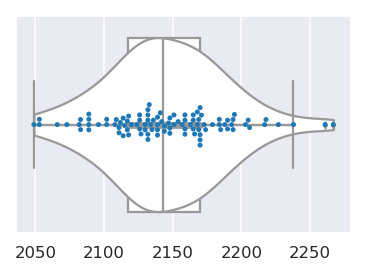

In [20]:
# Now, visualize the distribution
sns.boxplot(results, color='white')
sns.violinplot(results, color='white', cut=0)
sns.swarmplot(results)
plt.show()

In [21]:
# See the maximum number of times we had to toss the globe out of our 100 experiments
max(results)

2267

_(ignore the error, it is coming from seaborn using something from scipy that, in a future release, won't be supported)._

What we see from above is that the number of times we will need to toss the globe to get our 99% percentile interval of the posterior of p to be only 0.05 wide varies a bit based on the exact results of our runs (as we might expect.  However, if we toss the globe about 2,250 times, we expect to meet this threshold more often than not (for our experiments, all but two of them met this threshold by then, with the longest experiment taking 2,267 trials -- also, to note, rerunning the notebook can give different results, due to the random sampling that happens above).

------

### Matching the given solutions
What we see above is consistent with what is given in the solutions -- specifically, we need to toss the globe over 2,000 times to get our 99% percentile interval to be narrower than 0.05.  However, as the solution makes a good point about the return in what our models can learn from additional data, let's re-create it here.

In [22]:
# Now, we want a function that, given a size (number of times to toss the globe)
# it returns what the size of the 99% percentile interval is
def get_PI_size(N):
    """
    N {int} -- specify the number of times to toss the globe
    
    Returns:
    {float} -- the size of the 99% percentile interval
    """
    
    # Set the actual proportion of water on earth
    true_p = 0.7
    
    # Set, for the number of runs we want, the results of all our tosses
    results = sps.binom.rvs(N, p=true_p)
    
    # Set the grid to do our grid approximation on
    p_grid = np.linspace(0, 1, 1_000)
    
    # Set the prior
    prior = np.ones(1_000)
    
    # Set the likelihood 
    likelihood = sps.binom.pmf(k=results, n=N, p=p_grid)
    
    # Calculate the raw posterior
    raw_posterior = likelihood * prior
    
    # and normalize it
    posterior = raw_posterior / raw_posterior.sum()
    
    # Draw samples from this distribution
    samples = np.random.choice(p_grid, size=int(1e4), replace=True, p=posterior)
    
    # Now, find the 99% percentile interval
    interval = np.percentile(samples, [0.5, 99.5])
    
    # Return the difference between the upper and lower events
    return interval[1] - interval[0]

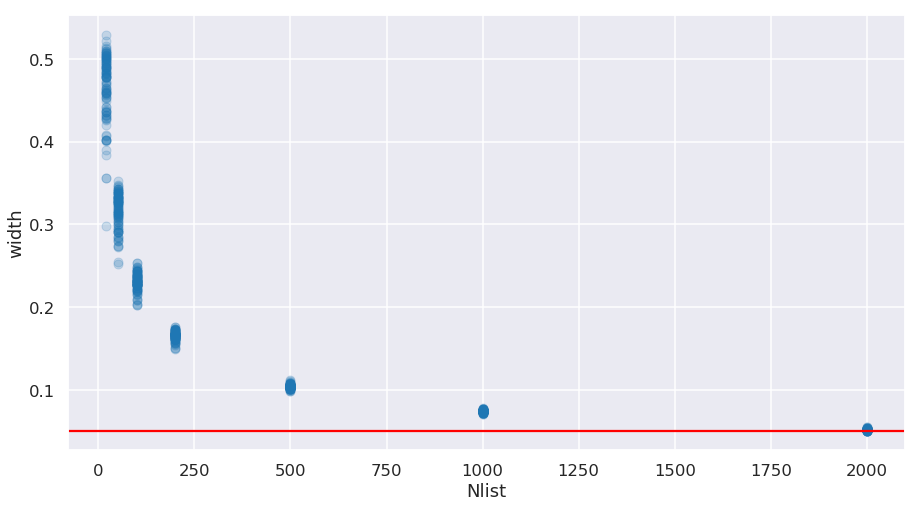

In [23]:
# Now, for the same list of the number of trials as was done in the solutions, run our
# function 100 times (100 experiments of tossing the globe N times each)
Nlist = (20, 50, 100, 200, 500, 1_000, 2_000)
Nlist = np.repeat(Nlist, 100)
width = [get_PI_size(x) for x in Nlist]
f = plt.figure(figsize=(15,8))
plt.plot(Nlist, width, 'o', alpha=0.2)
plt.axhline(0.05, color='red')
plt.xlabel('Nlist')
plt.ylabel('width')
plt.show()

We see above that we have re-created the plot from the solutions fairly well.  The main point from the solutions that I think is valuable is the observation that there is diminishing returns to the additional increase in precision additional data provides.  To quote from the solutions:

>>
The above is a general feature of learning from data: <mark>The greatest returns
on learning come early on</mark>. Each additional observation contributes less and
less. So it takes very much effort to progressively reduce our uncertainty. So
if your application requires a very precise estimate, be prepared to collect a
lot of data. Or to change your approach